# Correlation function of DR72 SDSS VAGC Catalog

First import all the modules such as healpy and astropy needed for analyzing the structure

In [1]:
import healpix_util as hu
import astropy as ap
import numpy as np
from astropy.io import fits
from astropy.table import Table
import astropy.io.ascii as ascii
from astropy.io import fits
from astropy.constants import c
import matplotlib.pyplot as plt
import math as m
from math import pi
import scipy.special as sp
from scipy import integrate
import warnings
from sklearn.neighbors import BallTree
import pickle
import pymangle
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
dr7full=ascii.read("./input/DR7-Full.ascii")
dr7full

col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12
float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64
56.1604523761,-0.221359772462,0.4501842,-22.0970516205,0.9943343,0.310859,1.7112147,1.0,0.9901478,32763,33480,784
58.247844859,0.216329004672,0.3671646,-21.8688602448,0.9533011,0.7922078,0.9208817,1.0,0.9506173,303471,311902,3790
54.445380928,0.619974218725,0.4133244,-21.7306137085,1.0,0.4315305,1.4082278,1.0,0.9183673,43630,44552,779
54.4879828915,0.485825651457,0.3224697,-21.8775806427,1.0,0.9240486,0.8174705,1.0,0.9183673,43622,44544,779
54.4932987631,0.483249792951,0.3226457,-21.6763000488,1.0,0.9249313,0.8168564,1.0,0.9183673,43622,44544,779
55.5558858448,0.582441686132,0.2334688,-21.5131568909,0.9943343,1.0009493,0.7672175,1.0,0.9901478,43723,44650,784
55.5686146471,0.608277412471,0.3136448,-21.5073776245,0.9943343,0.8425107,0.8784812,1.0,0.9901478,43727,44654,784
55.5972002797,0.434026434704,0.3517163,-21.5829257965,0.9943343,0.8903325,0.8416406,1.0,0.9901478,43731,44658,784
55.7617273511,0.495315330472,0.403208,-21.3501148224,0.9943343,0.4957986,1.2868758,1.0,0.9901478,43740,44667,784


In [3]:
z=dr7full['col3']
rad=dr7full['col1']
decd=dr7full['col2']

In [4]:
#Ez = lambda x: 1.0/m.sqrt(0.3*(1+x)**3+0.7)
Om=0.3
Ol=0.7
Ok=0.0
def Ez(zv):
    return 1.0/m.sqrt(Om*(1.0+zv)**3+Ok*(1.0+zv)**2+Ol)

np.vectorize(Ez)
#Calculate comoving distance of a data point using the Redshift - This definition is based on the cosmology model we take. Here the distance for E-dS universe is considered. Also note that c/H0 ratio is cancelled in the equations and hence not taken.

In [5]:
def DC_LCDM(z):
  return integrate.quad(Ez, 0, z)[0]
DC_LCDM=np.vectorize(DC_LCDM)

In [6]:
DC_LCDM(2.0)

array(1.20947120427111)

In [7]:
DC=DC_LCDM(z)
DC

0.402352474282
0.335419291795
0.373032638536
0.298038494099
0.298187560536
0.220751783751
0.290545079047
0.322606521262
0.364874955446
0.343444015506
0.162121950353


In [8]:
dr7f = open("./output/DR72srarflcdm2.dat",'w')
dr7f.write("z\t ra\t dec\t s\t rar\t decr \n")

for i in range(0,len(dr7full)):
    dr7f.write("%f\t " %z[i])
    dr7f.write("%f\t %f\t " %(rad[i],decd[i]))
    dr7f.write("%f\t " %DC[i])
    dr7f.write("%f\t %f\n " %(rad[i]*pi/180.0,decd[i]*pi/180.0))
dr7f.close()

In [9]:
data=ascii.read("./output/DR72srarflcdm2.dat")

In [10]:
data['z']

0.450184
0.367165
0.413324
0.32247
0.322646
0.233469
0.313645
0.351716
0.403208
0.37691
0.168714


In [ ]:
data['s']

In [ ]:
data['rar']

In [ ]:
data['decr']

In [10]:
NSIDE=512
dr72hpix=hu.HealPix("ring",NSIDE)

In [11]:
pixdata = open("./output/pixdatadr72VAGCfulllcdm2.dat",'w')
pixdata.write("z\t pix \n")

for i in range(0,len(data)):
    pixdata.write("%f\t" %data['z'][i])
    pixdata.write("%d\n" %dr72hpix.eq2pix(data['ra'][i],data['dec'][i]))
pixdata.close()

In [12]:
pixdata = ascii.read("./output/pixdatadr72VAGCfulllcdm2.dat")
hpixdata=np.array(np.zeros(hu.nside2npix(NSIDE)))
for j in range(len(pixdata)):
    hpixdata[pixdata[j]['pix']]+=1

In [13]:
hpixdata

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

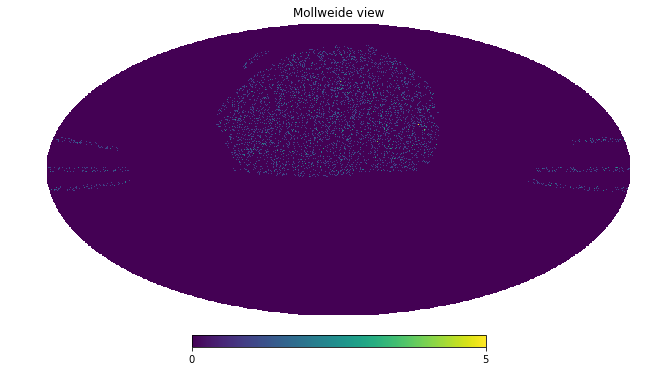

In [14]:
hu.mollview(hpixdata,rot=180)

In [27]:
dat=ascii.read("./output/DR72srarflcdm2.dat")

In [28]:
dat=np.array([dat['s'],dat['rar'],dat['decr']])

In [29]:
dat.reshape(3,len(data['s']))

array([[ 0.402352,  0.335419,  0.373033, ...,  0.336202,  0.209897,
         0.318731],
       [ 0.980185,  1.016617,  0.950251, ...,  2.830242,  2.831786,
         2.838233],
       [-0.003863,  0.003776,  0.010821, ...,  0.172112,  0.173661,
         0.173055]])

In [30]:
dat=dat.transpose()

In [31]:
dat

array([[ 0.402352,  0.980185, -0.003863],
       [ 0.335419,  1.016617,  0.003776],
       [ 0.373033,  0.950251,  0.010821],
       ..., 
       [ 0.336202,  2.830242,  0.172112],
       [ 0.209897,  2.831786,  0.173661],
       [ 0.318731,  2.838233,  0.173055]])

In [32]:
from lcdmmetric import *

In [33]:
LCDMmetricsq(dat[0],dat[1])

0.004667005825221726

In [34]:
bins=np.arange(0.005,0.08,0.0025)

In [35]:
print bins

[ 0.005   0.0075  0.01    0.0125  0.015   0.0175  0.02    0.0225  0.025
  0.0275  0.03    0.0325  0.035   0.0375  0.04    0.0425  0.045   0.0475
  0.05    0.0525  0.055   0.0575  0.06    0.0625  0.065   0.0675  0.07
  0.0725  0.075   0.0775]


In [36]:
Nbins=len(bins)

In [37]:
Nbins

30

In [38]:
help(BallTree)

Help on class BallTree in module sklearn.neighbors.ball_tree:

class BallTree(BinaryTree)
 |  BallTree for fast generalized N-point problems
 |  
 |  BallTree(X, leaf_size=40, metric='minkowski', \**kwargs)
 |  
 |  Parameters
 |  ----------
 |  X : array-like, shape = [n_samples, n_features]
 |      n_samples is the number of points in the data set, and
 |      n_features is the dimension of the parameter space.
 |      Note: if X is a C-contiguous array of doubles then data will
 |      not be copied. Otherwise, an internal copy will be made.
 |  
 |  leaf_size : positive integer (default = 40)
 |      Number of points at which to switch to brute-force. Changing
 |      leaf_size will not affect the results of a query, but can
 |      significantly impact the speed of a query and the memory required
 |      to store the constructed tree.  The amount of memory needed to
 |      store the tree scales as approximately n_samples / leaf_size.
 |      For a specified ``leaf_size``, a leaf 

In [39]:
%%time
BT_D = BallTree(dat,metric='pyfunc',func=LCDMmetricsq,leaf_size=15) 

with open('BTDdr72lcdm2.pkl', 'w') as f:
    pickle.dump(BT_D,f)

CPU times: user 4.7 s, sys: 39.2 ms, total: 4.74 s
Wall time: 4.78 s


In [40]:
with open('./BTDdr72lcdm2.pkl') as f:
    BTD = pickle.load(f)
    
BTD

In [41]:
binsq=bins**2
binsq

array([  2.50000000e-05,   5.62500000e-05,   1.00000000e-04,
         1.56250000e-04,   2.25000000e-04,   3.06250000e-04,
         4.00000000e-04,   5.06250000e-04,   6.25000000e-04,
         7.56250000e-04,   9.00000000e-04,   1.05625000e-03,
         1.22500000e-03,   1.40625000e-03,   1.60000000e-03,
         1.80625000e-03,   2.02500000e-03,   2.25625000e-03,
         2.50000000e-03,   2.75625000e-03,   3.02500000e-03,
         3.30625000e-03,   3.60000000e-03,   3.90625000e-03,
         4.22500000e-03,   4.55625000e-03,   4.90000000e-03,
         5.25625000e-03,   5.62500000e-03,   6.00625000e-03])

In [42]:
%%time
counts_DD=BTD.two_point_correlation(dat,binsq)
print counts_DD

[   406442    783136   1382684   2270899   3513678   5176855   7333793
  10041417  13381676  17412380  22217530  27872850  34442349  41988498
  50551940  60192281  70975145  82936326  96118334 110531804 126223404
 143261069 161641685 181385118 202520059 225089254 249138086 274647334
 301655034 330240869]
CPU times: user 23min 53s, sys: 3.84 s, total: 23min 57s
Wall time: 24min


In [43]:
with open('./DDDr72lcdm2.pkl', 'w') as f:
    pickle.dump(counts_DD,f)

with open('./DDDr72lcdm2.pkl') as f:
    counts_DD = pickle.load(f)
    
counts_DD

array([   406442,    783136,   1382684,   2270899,   3513678,   5176855,
         7333793,  10041417,  13381676,  17412380,  22217530,  27872850,
        34442349,  41988498,  50551940,  60192281,  70975145,  82936326,
        96118334, 110531804, 126223404, 143261069, 161641685, 181385118,
       202520059, 225089254, 249138086, 274647334, 301655034, 330240869])

In [44]:
DD=np.diff(counts_DD)
DD

array([  376694,   599548,   888215,  1242779,  1663177,  2156938,
        2707624,  3340259,  4030704,  4805150,  5655320,  6569499,
        7546149,  8563442,  9640341, 10782864, 11961181, 13182008,
       14413470, 15691600, 17037665, 18380616, 19743433, 21134941,
       22569195, 24048832, 25509248, 27007700, 28585835])

In [35]:
mangle=pymangle.Mangle("./masks/")

In [20]:
datR=ascii.read("./output/rand200kdr72.dat")

In [21]:
ra=datR['ra']
dec=datR['dec']

In [22]:
DCr=DC_LCDM(zr)

In [24]:
print len(zr)
print len(dec)

211662
211661


In [25]:
rdr7f = open("./output/rDR72srarflcdm2.dat",'w')
rdr7f.write("z\t ra\t dec\t s\t rar\t decr \n")

for i in range(0,len(zr)-1):
    rdr7f.write("%f\t " %zr[i])
    rdr7f.write("%f\t %f\t " %(ra[i],dec[i]))
    rdr7f.write("%f\t " %DCr[i])
    rdr7f.write("%f\t %f\n " %(ra[i]*pi/180.0,dec[i]*pi/180.0))
rdr7f.close()

Ref: https://pypi.python.org/pypi/pymangle/

In [ ]:
%%time
rar,decr=mangle.genrand(2*len(data))

In [13]:
rar

array([ 167.13535,  149.94692,  29.025466, ...,  170.09184,  163.78547,
        356.03997], dtype=float128)

In [14]:
decr

array([-0.88070859,  6.746407,  31.329933, ...,  24.982752,  44.375591,
        21.040094], dtype=float128)

In [15]:
zr=np.array([data['z'],data['z']])

In [16]:
zr

array([[ 0.450184,  0.367165,  0.413324, ...,  0.368113,  0.22131 ,
         0.34707 ],
       [ 0.450184,  0.367165,  0.413324, ...,  0.368113,  0.22131 ,
         0.34707 ]])

In [17]:
zr=zr.flatten()

In [18]:
zr

array([ 0.450184,  0.367165,  0.413324, ...,  0.368113,  0.22131 ,  0.34707 ])

In [19]:
print len(zr)
print len(decr)

211662


NameError: name 'decr' is not defined

In [45]:
dataR=ascii.read("./output/rDR72srarflcdm2.dat")

In [46]:
dataR['z']

0.450184
0.367165
0.413324
0.32247
0.322646
0.233469
0.313645
0.351716
0.403208
0.37691
0.168714


In [27]:
dat=ascii.read("./output/DR72srarflcdm2.dat")

In [47]:
datR=np.array([dataR['s'],dataR['rar'],dataR['decr']])

In [48]:
datR.reshape(3,len(dataR['s']))

array([[ 0.402352,  0.33542 ,  0.373032, ...,  0.310268,  0.336202,
         0.209897],
       [ 2.992549,  2.737752,  2.367643, ...,  3.228052,  3.218296,
         4.056418],
       [ 0.248026,  0.711236,  0.341962, ...,  0.199013,  0.052979,
         0.170602]])

In [49]:
datR=datR.transpose()

In [50]:
datR

array([[ 0.402352,  2.992549,  0.248026],
       [ 0.33542 ,  2.737752,  0.711236],
       [ 0.373032,  2.367643,  0.341962],
       ..., 
       [ 0.310268,  3.228052,  0.199013],
       [ 0.336202,  3.218296,  0.052979],
       [ 0.209897,  4.056418,  0.170602]])

In [51]:
from lcdmmetric import *

In [53]:
LCDMmetricsq(datR[0],datR[1])

0.03932220941339584

In [34]:
bins=np.arange(0.005,0.08,0.0025)

In [35]:
print bins

[ 0.005   0.0075  0.01    0.0125  0.015   0.0175  0.02    0.0225  0.025
  0.0275  0.03    0.0325  0.035   0.0375  0.04    0.0425  0.045   0.0475
  0.05    0.0525  0.055   0.0575  0.06    0.0625  0.065   0.0675  0.07
  0.0725  0.075   0.0775]


In [36]:
Nbins=len(bins)

In [37]:
Nbins

30

In [38]:
help(BallTree)

Help on class BallTree in module sklearn.neighbors.ball_tree:

class BallTree(BinaryTree)
 |  BallTree for fast generalized N-point problems
 |  
 |  BallTree(X, leaf_size=40, metric='minkowski', \**kwargs)
 |  
 |  Parameters
 |  ----------
 |  X : array-like, shape = [n_samples, n_features]
 |      n_samples is the number of points in the data set, and
 |      n_features is the dimension of the parameter space.
 |      Note: if X is a C-contiguous array of doubles then data will
 |      not be copied. Otherwise, an internal copy will be made.
 |  
 |  leaf_size : positive integer (default = 40)
 |      Number of points at which to switch to brute-force. Changing
 |      leaf_size will not affect the results of a query, but can
 |      significantly impact the speed of a query and the memory required
 |      to store the constructed tree.  The amount of memory needed to
 |      store the tree scales as approximately n_samples / leaf_size.
 |      For a specified ``leaf_size``, a leaf 

In [77]:
%%time
BT_R = BallTree(datR,metric='pyfunc',func=LCDMmetricsq,leaf_size=15) 

with open('BTRdr72lcdm2.pkl', 'w') as f:
    pickle.dump(BT_R,f)

CPU times: user 9.55 s, sys: 76.3 ms, total: 9.63 s
Wall time: 9.71 s


In [78]:
with open('./BTRdr72lcdm2.pkl') as f:
    BTR = pickle.load(f)
    
BTR

In [79]:
binsq=bins**2
binsq

array([  2.50000000e-05,   5.62500000e-05,   1.00000000e-04,
         1.56250000e-04,   2.25000000e-04,   3.06250000e-04,
         4.00000000e-04,   5.06250000e-04,   6.25000000e-04,
         7.56250000e-04,   9.00000000e-04,   1.05625000e-03,
         1.22500000e-03,   1.40625000e-03,   1.60000000e-03,
         1.80625000e-03,   2.02500000e-03,   2.25625000e-03,
         2.50000000e-03,   2.75625000e-03,   3.02500000e-03,
         3.30625000e-03,   3.60000000e-03,   3.90625000e-03,
         4.22500000e-03,   4.55625000e-03,   4.90000000e-03,
         5.25625000e-03,   5.62500000e-03,   6.00625000e-03])

In [80]:
%%time
counts_RR=BTR.two_point_correlation(datR,binsq)
print counts_RR

[    671975    1717251    3680670    6828077   11399544   17645392
   25816652   36207881   49151165   64924463   83824631  106109931
  131983556  161714973  195475210  233472001  275891024  322861741
  374548127  431075255  492644147  559354671  631376635  708769062
  791638524  880028237  974028647 1073638771 1178989759 1290107093]
CPU times: user 1h 12min 56s, sys: 11.4 s, total: 1h 13min 7s
Wall time: 1h 13min 21s


In [81]:
with open('./RRDr72lcdm2.pkl', 'w') as f:
    pickle.dump(counts_RR,f)

with open('./RRDr72lcdm2.pkl') as f:
    counts_RR = pickle.load(f)
    
counts_RR

array([    671975,    1717251,    3680670,    6828077,   11399544,
         17645392,   25816652,   36207881,   49151165,   64924463,
         83824631,  106109931,  131983556,  161714973,  195475210,
        233472001,  275891024,  322861741,  374548127,  431075255,
        492644147,  559354671,  631376635,  708769062,  791638524,
        880028237,  974028647, 1073638771, 1178989759, 1290107093])

In [82]:
RR=np.diff(counts_RR)
RR

array([  1045276,   1963419,   3147407,   4571467,   6245848,   8171260,
        10391229,  12943284,  15773298,  18900168,  22285300,  25873625,
        29731417,  33760237,  37996791,  42419023,  46970717,  51686386,
        56527128,  61568892,  66710524,  72021964,  77392427,  82869462,
        88389713,  94000410,  99610124, 105350988, 111117334])

In [83]:
%%time
counts_DR=BTR.two_point_correlation(dat,binsq)
print counts_DR

[   225550    745522   1729932   3302810   5594370   8725926  12834422
  18070091  24591341  32560326  42109823  53357438  66419001  81441796
  98514188 117703247 139140894 162904498 189092169 217693163 248853960
 282653586 319118232 358309151 400298837 445138054 492923309 543534407
 597055546 653423802]
CPU times: user 36min 48s, sys: 3.31 s, total: 36min 51s
Wall time: 36min 54s


In [84]:
with open('./DRDr72lcdm2.pkl', 'w') as f:
    pickle.dump(counts_DR,f)

with open('./DRDr72lcdm2.pkl') as f:
    counts_DR = pickle.load(f)
    
counts_DR

array([   225550,    745522,   1729932,   3302810,   5594370,   8725926,
        12834422,  18070091,  24591341,  32560326,  42109823,  53357438,
        66419001,  81441796,  98514188, 117703247, 139140894, 162904498,
       189092169, 217693163, 248853960, 282653586, 319118232, 358309151,
       400298837, 445138054, 492923309, 543534407, 597055546, 653423802])

In [85]:
DR=np.diff(counts_DR)
DR

array([  519972,   984410,  1572878,  2291560,  3131556,  4108496,
        5235669,  6521250,  7968985,  9549497, 11247615, 13061563,
       15022795, 17072392, 19189059, 21437647, 23763604, 26187671,
       28600994, 31160797, 33799626, 36464646, 39190919, 41989686,
       44839217, 47785255, 50611098, 53521139, 56368256])

In [86]:
DD

array([  376694,   599548,   888215,  1242779,  1663177,  2156938,
        2707624,  3340259,  4030704,  4805150,  5655320,  6569499,
        7546149,  8563442,  9640341, 10782864, 11961181, 13182008,
       14413470, 15691600, 17037665, 18380616, 19743433, 21134941,
       22569195, 24048832, 25509248, 27007700, 28585835])

In [87]:
RR

array([  1045276,   1963419,   3147407,   4571467,   6245848,   8171260,
        10391229,  12943284,  15773298,  18900168,  22285300,  25873625,
        29731417,  33760237,  37996791,  42419023,  46970717,  51686386,
        56527128,  61568892,  66710524,  72021964,  77392427,  82869462,
        88389713,  94000410,  99610124, 105350988, 111117334])

In [66]:
DR

array([  376694,   599548,   888215,  1242779,  1663177,  2156938,
        2707624,  3340259,  4030704,  4805150,  5655320,  6569499,
        7546149,  8563442,  9640341, 10782864, 11961181, 13182008,
       14413470, 15691600, 17037665, 18380616, 19743433, 21134941,
       22569195, 24048832, 25509248, 27007700, 28585835])

In [67]:
4.0*DD

array([  1.50677600e+06,   2.39819200e+06,   3.55286000e+06,
         4.97111600e+06,   6.65270800e+06,   8.62775200e+06,
         1.08304960e+07,   1.33610360e+07,   1.61228160e+07,
         1.92206000e+07,   2.26212800e+07,   2.62779960e+07,
         3.01845960e+07,   3.42537680e+07,   3.85613640e+07,
         4.31314560e+07,   4.78447240e+07,   5.27280320e+07,
         5.76538800e+07,   6.27664000e+07,   6.81506600e+07,
         7.35224640e+07,   7.89737320e+07,   8.45397640e+07,
         9.02767800e+07,   9.61953280e+07,   1.02036992e+08,
         1.08030800e+08,   1.14343340e+08])

In [88]:
correl=(4.0*DD+1.0*RR-4.0*DR)/(1.0*RR)

In [89]:
correl

array([  4.51712275e-01,   2.15935060e-01,   1.29870398e-01,
         8.23243392e-02,   5.96127219e-02,   4.46721803e-02,
         2.68542826e-02,   1.69446950e-02,   1.27899695e-03,
        -4.08567797e-03,  -3.76391612e-03,  -3.65743107e-03,
        -5.89164654e-03,  -8.16235384e-03,  -5.21309813e-03,
        -4.71743538e-03,  -5.08774435e-03,  -6.50589113e-03,
        -3.94444239e-03,  -5.00083711e-03,  -5.05647355e-03,
        -4.36194714e-03,  -5.13638111e-03,  -6.63112788e-03,
        -7.81058085e-03,  -1.00561476e-02,  -8.00396554e-03,
        -6.67073004e-03,  -1.11143775e-04])

In [90]:
binMpc=c*1e-5*bins[1:len(bins)]
print binMpc

[  22.48443435   29.9792458    37.47405725   44.9688687    52.46368015
   59.9584916    67.45330305   74.9481145    82.44292595   89.9377374
   97.43254885  104.9273603   112.42217175  119.9169832   127.41179465
  134.9066061   142.40141755  149.896229    157.39104045  164.8858519
  172.38066335  179.8754748   187.37028625  194.8650977   202.35990915
  209.8547206   217.34953205  224.8443435   232.33915495] m / s


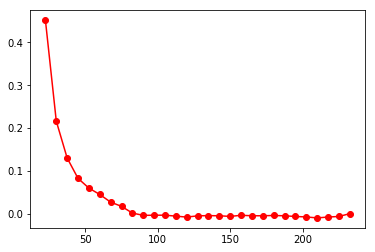

In [91]:
plt.plot(binMpc,correl,'ro-')

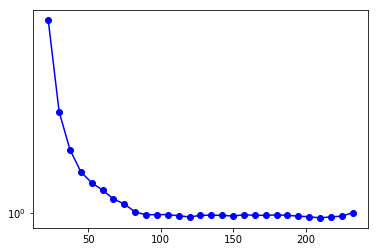

In [93]:
plt.yscale('log')
plt.plot(binMpc,correl+1.0,'bo-')
plt.show()

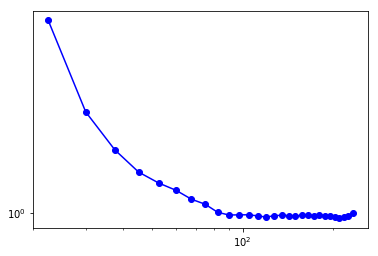

In [94]:
plt.xscale('log')
plt.yscale('log')
plt.plot(binMpc,correl+1.0,'bo-')
plt.show()

In [ ]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

In [ ]:
from lcdmmetric import *

In [ ]:
z=np.array(data['z'])

In [ ]:
zkde=z.reshape(1,-1)

In [ ]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(zkde)

In [ ]:
kde

In [ ]:
X_plot = np.arange(z.min(), z.max(), z.size())[:, np.newaxis]

In [ ]:
log_dens = kde.score_samples(zkde)

In [ ]:
log_dens

In [ ]:
d=ascii.read("./output/DR72LCsrarf.dat")

In [ ]:
d

In [ ]:
dataR=ascii.read("./output/rand200kdr72.dat")

In [ ]:
dataR['z']

In [ ]:
dataR['ra']

In [ ]:
dataR['dec']

In [ ]:
DCLCR=DC_LC(dataR['z'])

In [ ]:
rdr7f = open("./output/rDR7200kLCsrarf.dat",'w')
rdr7f.write("z\t ra\t dec\t s\t rar\t decr \n")

for i in range(0,len(dataR)):
    rdr7f.write("%f\t " %dataR['z'][i])
    rdr7f.write("%f\t %f\t " %(dataR['ra'][i],dataR['dec'][i]))
    rdr7f.write("%f\t " %DCLCR[i])
    rdr7f.write("%f\t %f\n " %(dataR['ra'][i]*pi/180.0,dataR['dec'][i]*pi/180.0))
rdr7f.close()

In [ ]:
r=ascii.read("./output/rDR7200kLCsrarf.dat")

In [ ]:
r

In [ ]:
dr7fdat=ascii.read("./output/DR7srarf.dat")

In [ ]:
dr7fdat['s'][1:300]

In [ ]:
#fdata=fits.open("/Users/rohin/Downloads/DR7-Full.fits")

In [ ]:
#fdata.writeto("./output/DR7fulltrim.fits")

In [ ]:
fdata=fits.open("./output/DR7fulltrim.fits")

In [ ]:
cols=fdata[1].columns

In [ ]:
cols.del_col('ZTYPE')

In [ ]:
cols.del_col('SECTOR')
cols.del_col('FGOTMAIN')
cols.del_col('QUALITY')
cols.del_col('ISBAD')
cols.del_col('M')
cols.del_col('MMAX')
cols.del_col('ILSS')
cols.del_col('ICOMB')
cols.del_col('VAGC_SELECT')
cols.del_col('LSS_INDEX')
cols.del_col('FIBERWEIGHT')
cols.del_col('PRIMTARGET')
cols.del_col('MG')
cols.del_col('SECTOR_COMPLETENESS')
cols.del_col('COMOV_DENSITY')
cols.del_col('RADIAL_WEIGHT')

In [ ]:
fdata[1].columns

In [ ]:
fdata.writeto("./output/DR7fullzradec.fits")

In [ ]:
fdat=fits.open("./output/DR7fullzradec.fits")

In [ ]:
fdat[1].columns

In [ ]:
fdat[1].data['Z']

In [ ]:
fdat[1].data['RA']

In [ ]:
comovlcdm=DC_LCDM(fdat[1].data['Z'])

In [ ]:
fdat[1].data['Z']

In [ ]:
comovlcdm

In [ ]:
comovlcdm.dtype

In [ ]:
#cols=fdat[1].columns

In [ ]:
nc=fits.Column(name='COMOV',format='D',array=comovlcdm)

In [ ]:
nc1=fits.Column(name='COMOV',format='D')

In [ ]:
fdata[1].data['Z']

In [ ]:
fdata[1].data['RA']

In [ ]:
nc

In [ ]:
nc.dtype

In [ ]:
#cols.add_col(nc)

In [ ]:
fdat[1].columns

In [ ]:
fdat[1].columns.info()

In [ ]:
fdat[1].columns.add_col(nc1)

In [ ]:
fdat[1].data['COMOV']=comovlcdm

In [ ]:
comovlcdm

In [ ]:
fdat[1].data['Z']

In [ ]:
fdat[1].data['COMOV']

In [ ]:
fdat[1].data['RA']

In [ ]:
fdat[1].data['RA']=fdat[1].data['RA']*pi/180.0

In [ ]:
comovlcdm=DC_LCDM(fdat[1].data['Z'])
comovlcdm

Random catalog created based on the survey limitations also taken from http://cosmo.nyu.edu/~eak306/SDSS-LRG.html

In [ ]:
dataR=fits.open("/Users/rohin/Downloads/random-DR7-Full.fits")

In [ ]:
dataR

In [ ]:
dataR=dataR[1].data

In [ ]:
len(dataR)

In [ ]:
NSIDE=512
dr72hpix=hu.HealPix("ring",NSIDE)

In [ ]:
pixdata = open("./output/pixdatadr72VAGCfullrand.dat",'w')
pixdata.write("z\t pix \n")

for i in range(0,len(data)-1):
    pixdata.write("%f\t" %data['z'][i])
    pixdata.write("%d\n" %dr72hpix.eq2pix(dataR['ra'][i],dataR['dec'][i]))
pixdata.close()

In [ ]:
pixdata = ascii.read("./output/pixdatadr72VAGCfullrand.dat")
hpixdata=np.array(np.zeros(hu.nside2npix(NSIDE)))
for j in range(len(pixdata)):
    hpixdata[pixdata[j]['pix']]+=1

In [ ]:
hpixdata

In [ ]:
hu.mollview(hpixdata,rot=180)

In [ ]:
hu.orthview(hpixdata)